# Blood cell images classification with CNN

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, RMSprop , SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Unzip the Datasets Folder

In [4]:
import zipfile
local_zip = '//tmp/dataset2-master.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/dataset2-master'

### Exploring and Visualizing the Cell Datasets

In [5]:
os.listdir(base_dir)

['dataset2-master']

In [ ]:
datasets = os.listdir(base_dir+'/dataset2-master')
datasets

['labels.csv', 'images']

In [ ]:
labels = pd.read_csv('/tmp/dataset2-master/dataset2-master/labels.csv')

In [ ]:
labels.head()

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL


In [6]:
images_path = '/tmp/dataset2-master/dataset2-master/images'
os.listdir(images_path)

['TRAIN', 'TEST_SIMPLE', 'TEST']

In [7]:
training_path = images_path+'/TRAIN'
validation_path = images_path+'/TEST'
testing_path = images_path+'/TEST_SIMPLE'

In [8]:
os.listdir(testing_path)

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']

### Data Pre-processing for Model 

In [ ]:


'''
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
'''
#Training data 
train_datagen = ImageDataGenerator(rescale = 1./255.)
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(training_path,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (120, 160))  

#validation data
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = train_datagen.flow_from_directory(validation_path,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (120, 160))  

#Testing data
testing_datagen = ImageDataGenerator(rescale = 1./255)
testing_generator = train_datagen.flow_from_directory(testing_path,
                                                    batch_size = 4,
                                                    class_mode = 'categorical', 
                                                    target_size = (120, 160))  


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


### Exploring of Classes

In [ ]:
imgs, labels = next(testing_generator)
labels

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
testing_generator.class_indices

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

### Visualizing Images

In [ ]:
#plot images with labels
def plot_images(ims, figsize=(12,16), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims)%2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

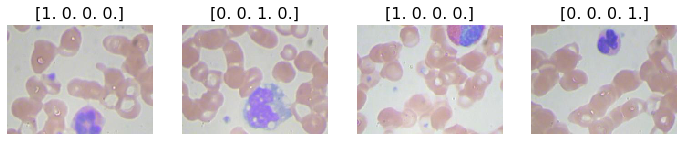

In [ ]:
plot_images(imgs[:10], titles=labels)

### Building and Training a simple model

In [ ]:
# Define the first simple model
first_model = Sequential()

first_model.add(Conv2D(4, 5, strides=(4, 4), padding='same', activation='relu', input_shape=(120, 160, 3)))
first_model.add(Conv2D(4, 5, strides=(4, 4), padding='same', activation='relu'))
first_model.add(Flatten())
first_model.add(Dense(16, activation='relu'))
first_model.add(Dense(4, activation='softmax'))

In [ ]:
first_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
first_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 40, 4)         304       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 10, 4)          404       
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5136      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 5,912
Trainable params: 5,912
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training the first simple model
first_model.fit_generator(train_generator, 
                    steps_per_epoch=200,
                    validation_data=validation_generator,
                    validation_steps=20,
                    epochs=25, verbose=2)

Epoch 1/25
 - 139s - loss: 1.3893 - accuracy: 0.2553 - val_loss: 1.3854 - val_accuracy: 0.2500
Epoch 2/25
 - 111s - loss: 1.3870 - accuracy: 0.2404 - val_loss: 1.3857 - val_accuracy: 0.2700
Epoch 3/25
 - 73s - loss: 1.3863 - accuracy: 0.2450 - val_loss: 1.3820 - val_accuracy: 0.2700
Epoch 4/25
 - 13s - loss: 1.3860 - accuracy: 0.2605 - val_loss: 1.3939 - val_accuracy: 0.2275
Epoch 5/25
 - 12s - loss: 1.3858 - accuracy: 0.2554 - val_loss: 1.3887 - val_accuracy: 0.2525
Epoch 6/25
 - 12s - loss: 1.3850 - accuracy: 0.2612 - val_loss: 1.3805 - val_accuracy: 0.2200
Epoch 7/25
 - 9s - loss: 1.3850 - accuracy: 0.2618 - val_loss: 1.3871 - val_accuracy: 0.2584
Epoch 8/25
 - 9s - loss: 1.3845 - accuracy: 0.2742 - val_loss: 1.3925 - val_accuracy: 0.2550
Epoch 9/25
 - 9s - loss: 1.3829 - accuracy: 0.2702 - val_loss: 1.3701 - val_accuracy: 0.2275
Epoch 10/25
 - 9s - loss: 1.3835 - accuracy: 0.2725 - val_loss: 1.4000 - val_accuracy: 0.2425
Epoch 11/25
 - 9s - loss: 1.3783 - accuracy: 0.2733 - val_los

In [ ]:
first_model_loss = pd.DataFrame(first_model.history.history)
first_model_loss.head()

,val_loss,val_accuracy,loss,accuracy
0,1.385404,0.2500,1.389332,0.255250
1,1.385697,0.2700,1.387022,0.240430
2,1.381998,0.2700,1.386297,0.245000
3,1.393948,0.2275,1.386035,0.260500
4,1.388717,0.2525,1.385828,0.255442


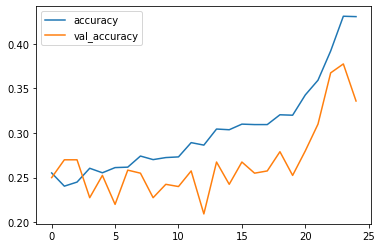

In [ ]:
first_model_loss[['accuracy','val_accuracy']].plot()

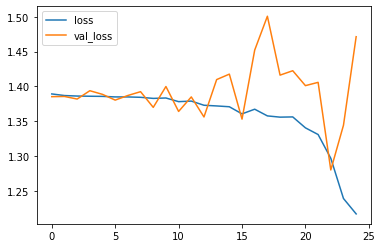

In [ ]:
first_model_loss[['loss','val_loss']].plot()

### Final Model with Regularization
    ** BatchNormalization
    ** Dropout [20% dropout]

In [ ]:
# Define the final model
final_model = Sequential()

final_model.add(Conv2D(16, 5, strides=(2, 2), padding='same', activation='relu', input_shape=(120, 160, 3)))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.2))

final_model.add(Conv2D(8, 5, strides=(2, 2), padding='same', activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.2))

final_model.add(Conv2D(4, 5, strides=(2, 2), padding='same', activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.2))

final_model.add(Conv2D(4, 5, strides=(2, 2), padding='same', activation='relu'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.2))

final_model.add(Flatten())

final_model.add(Dense(32, activation='relu'))
final_model.add(Dropout(0.2))

final_model.add(Dense(16, activation='relu'))
final_model.add(Dropout(0.2))

final_model.add(Dense(8, activation='relu'))
final_model.add(Dropout(0.2))

final_model.add(Dense(4, activation='softmax'))

In [ ]:
final_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 60, 80, 16)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 80, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 40, 8)         3208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 40, 8)         32        
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 20, 4)        

In [ ]:
#Training the final model
final_model.fit_generator(train_generator, 
                    steps_per_epoch=200,
                    validation_data=validation_generator,
                    validation_steps=20,
                    epochs=50, verbose=2)

Epoch 1/50
 - 153s - loss: 1.4358 - accuracy: 0.2643 - val_loss: 1.3875 - val_accuracy: 0.2500
Epoch 2/50
 - 106s - loss: 1.3930 - accuracy: 0.2474 - val_loss: 1.3896 - val_accuracy: 0.2650
Epoch 3/50
 - 81s - loss: 1.3888 - accuracy: 0.2615 - val_loss: 1.3996 - val_accuracy: 0.2300
Epoch 4/50
 - 79s - loss: 1.3886 - accuracy: 0.2707 - val_loss: 1.4507 - val_accuracy: 0.2500
Epoch 5/50
 - 122s - loss: 1.3810 - accuracy: 0.2842 - val_loss: 1.3844 - val_accuracy: 0.2575
Epoch 6/50
 - 61s - loss: 1.3698 - accuracy: 0.2937 - val_loss: 1.4819 - val_accuracy: 0.3050
Epoch 7/50
 - 57s - loss: 1.3596 - accuracy: 0.3067 - val_loss: 2.4292 - val_accuracy: 0.2636
Epoch 8/50
 - 69s - loss: 1.3624 - accuracy: 0.3145 - val_loss: 2.2943 - val_accuracy: 0.2775
Epoch 9/50
 - 44s - loss: 1.3505 - accuracy: 0.3268 - val_loss: 2.0811 - val_accuracy: 0.2550
Epoch 10/50
 - 43s - loss: 1.3426 - accuracy: 0.3203 - val_loss: 3.6079 - val_accuracy: 0.2450
Epoch 11/50
 - 39s - loss: 1.3453 - accuracy: 0.3210 - v

In [ ]:
final_model_loss = pd.DataFrame(final_model.history.history)
final_model_loss.head()

,val_loss,val_accuracy,loss,accuracy
0,1.387478,0.2500,1.435808,0.264250
1,1.389564,0.2650,1.393048,0.247436
2,1.399556,0.2300,1.388776,0.261500
3,1.450656,0.2500,1.388640,0.270703
4,1.384447,0.2575,1.380988,0.284250


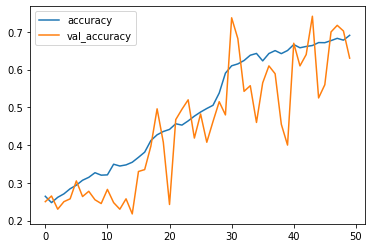

In [ ]:
final_model_loss[['accuracy','val_accuracy']].plot()

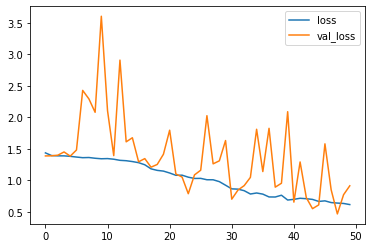

In [ ]:
final_model_loss[['loss','val_loss']].plot()

In [ ]:
#Training the final model
final_model.fit_generator(train_generator, 
                    steps_per_epoch=200,
                    validation_data=validation_generator,
                    validation_steps=20,
                    epochs=200, verbose=2)

Epoch 1/200
 - 162s - loss: 1.4254 - accuracy: 0.2662 - val_loss: 1.3981 - val_accuracy: 0.2550
Epoch 2/200
 - 112s - loss: 1.3892 - accuracy: 0.2682 - val_loss: 1.3785 - val_accuracy: 0.2875
Epoch 3/200
 - 70s - loss: 1.3858 - accuracy: 0.2634 - val_loss: 1.4034 - val_accuracy: 0.2525
Epoch 4/200
 - 40s - loss: 1.3851 - accuracy: 0.2615 - val_loss: 1.3841 - val_accuracy: 0.2550
Epoch 5/200
 - 40s - loss: 1.3755 - accuracy: 0.2907 - val_loss: 8.4680 - val_accuracy: 0.2100
Epoch 6/200
 - 40s - loss: 1.3615 - accuracy: 0.3070 - val_loss: 1.3221 - val_accuracy: 0.2825
Epoch 7/200
 - 40s - loss: 1.3599 - accuracy: 0.2960 - val_loss: 1.3444 - val_accuracy: 0.2739
Epoch 8/200
 - 51s - loss: 1.3544 - accuracy: 0.3215 - val_loss: 1.4002 - val_accuracy: 0.2375
Epoch 9/200
 - 45s - loss: 1.3322 - accuracy: 0.3368 - val_loss: 5.0975 - val_accuracy: 0.2350
Epoch 10/200
 - 44s - loss: 1.3013 - accuracy: 0.3553 - val_loss: 1.4414 - val_accuracy: 0.3600
Epoch 11/200
 - 42s - loss: 1.2655 - accuracy: 

Epoch 87/200
 - 42s - loss: 0.5285 - accuracy: 0.7025 - val_loss: 2.1026 - val_accuracy: 0.6375
Epoch 88/200
 - 43s - loss: 0.5393 - accuracy: 0.6913 - val_loss: 0.7710 - val_accuracy: 0.6951
Epoch 89/200
 - 41s - loss: 0.5347 - accuracy: 0.6967 - val_loss: 1.0530 - val_accuracy: 0.7000
Epoch 90/200
 - 37s - loss: 0.5292 - accuracy: 0.6973 - val_loss: 0.8769 - val_accuracy: 0.6250
Epoch 91/200
 - 40s - loss: 0.5234 - accuracy: 0.7013 - val_loss: 0.7009 - val_accuracy: 0.5475
Epoch 92/200
 - 42s - loss: 0.5362 - accuracy: 0.6950 - val_loss: 1.6465 - val_accuracy: 0.5150
Epoch 93/200
 - 39s - loss: 0.5493 - accuracy: 0.6917 - val_loss: 0.6392 - val_accuracy: 0.6200
Epoch 94/200
 - 38s - loss: 0.5341 - accuracy: 0.6898 - val_loss: 1.5837 - val_accuracy: 0.5297
Epoch 95/200
 - 39s - loss: 0.5532 - accuracy: 0.6973 - val_loss: 0.8925 - val_accuracy: 0.6700
Epoch 96/200
 - 43s - loss: 0.5361 - accuracy: 0.7033 - val_loss: 0.4295 - val_accuracy: 0.6375
Epoch 97/200
 - 42s - loss: 0.5117 - acc

Epoch 172/200
 - 39s - loss: 0.4742 - accuracy: 0.7258 - val_loss: 1.8100 - val_accuracy: 0.6250
Epoch 173/200
 - 41s - loss: 0.4500 - accuracy: 0.7298 - val_loss: 0.3559 - val_accuracy: 0.6975
Epoch 174/200
 - 36s - loss: 0.4595 - accuracy: 0.7240 - val_loss: 1.0622 - val_accuracy: 0.6275
Epoch 175/200
 - 36s - loss: 0.4567 - accuracy: 0.7228 - val_loss: 0.3146 - val_accuracy: 0.6331
Epoch 176/200
 - 37s - loss: 0.4458 - accuracy: 0.7228 - val_loss: 0.6641 - val_accuracy: 0.6375
Epoch 177/200
 - 36s - loss: 0.4754 - accuracy: 0.7103 - val_loss: 1.1635 - val_accuracy: 0.6800
Epoch 178/200
 - 36s - loss: 0.4680 - accuracy: 0.7218 - val_loss: 3.0719 - val_accuracy: 0.5050
Epoch 179/200
 - 36s - loss: 0.4644 - accuracy: 0.7248 - val_loss: 0.2797 - val_accuracy: 0.7025
Epoch 180/200
 - 36s - loss: 0.4613 - accuracy: 0.7138 - val_loss: 1.7124 - val_accuracy: 0.5950
Epoch 181/200
 - 36s - loss: 0.4658 - accuracy: 0.7215 - val_loss: 0.3146 - val_accuracy: 0.7075
Epoch 182/200
 - 36s - loss: 0

In [ ]:
f_model_loss = pd.DataFrame(final_model.history.history)
f_model_loss.head()

,val_loss,val_accuracy,loss,accuracy
0,1.398066,0.2550,1.425437,0.266200
1,1.378461,0.2875,1.389204,0.268250
2,1.403396,0.2525,1.385813,0.263448
3,1.384069,0.2550,1.385115,0.261500
4,8.468012,0.2100,1.375517,0.290750


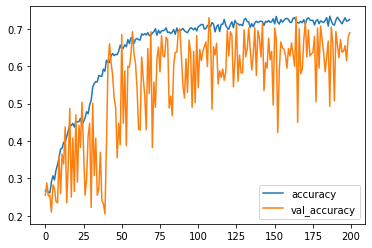

In [ ]:
f_model_loss[['accuracy','val_accuracy']].plot()

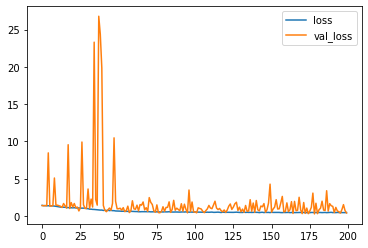

In [ ]:
f_model_loss[['loss','val_loss']].plot()

In [ ]:
final_model.save('first_blood_cell_classifier.h5')

In [ ]:
first_predictions = final_model.predict_generator(testing_generator)

In [ ]:
first_predictions.argmax(axis=1)

array([0, 0, 0, 3, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 2, 2, 1, 2, 2, 3, 2, 3,
       0, 2, 0, 0, 3, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1,
       0, 3, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2,
       0, 1, 2, 0, 3], dtype=int64)

In [ ]:
testing_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(testing_generator.classes,first_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.26      0.69      0.37        13
           1       0.12      0.17      0.14         6
           2       0.05      0.25      0.08         4
           3       0.50      0.06      0.11        48

    accuracy                           0.20        71
   macro avg       0.23      0.29      0.18        71
weighted avg       0.40      0.20      0.16        71



In [ ]:
print(confusion_matrix(testing_generator.classes,first_predictions.argmax(axis=1)))

[[ 9  2  1  1]
 [ 0  1  5  0]
 [ 1  0  1  2]
 [25  5 15  3]]


## VGG-16 with Data Augmentation

#### Data pre-processing with data augmentation

In [9]:
# Add our data-augmentation parameters to ImageDataGenerator
#Training data
train_batchsize = 20
val_batchsize = 20

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest', 
                                   validation_split=0.25)
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(training_path,
                                                    batch_size = train_batchsize,
                                                    class_mode = 'categorical', 
                                                    target_size = (120, 160))  

#validation data
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = train_datagen.flow_from_directory(validation_path,
                                                    batch_size = val_batchsize,
                                                    class_mode = 'categorical',
                                                    shuffle=False, 
                                                    target_size = (120, 160))  

#Testing data
testing_datagen = ImageDataGenerator(rescale = 1./255)
testing_generator = train_datagen.flow_from_directory(testing_path,
                                                    batch_size = 4,
                                                    class_mode = 'categorical', 
                                                    target_size = (120, 160))  

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


### Load VGG-16 model using keras

In [2]:
import keras.applications as app

Using TensorFlow backend.


In [3]:
vgg = app.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(120,160,3))

In [4]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 40, 128)       0     

### Make trainable False except last 4 layers

In [12]:
third_model = Sequential()

for layer in vgg.layers[:-4]:
  layer.trainable=False

In [13]:
for layer in vgg.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe38b96cdd8> False
<keras.layers.convolutional.Conv2D object at 0x7fe38b130320> False
<keras.layers.convolutional.Conv2D object at 0x7fe38b130588> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe38b130b38> False
<keras.layers.convolutional.Conv2D object at 0x7fe38b130828> False
<keras.layers.convolutional.Conv2D object at 0x7fe38975c630> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe389765470> False
<keras.layers.convolutional.Conv2D object at 0x7fe3897652b0> False
<keras.layers.convolutional.Conv2D object at 0x7fe389765f98> False
<keras.layers.convolutional.Conv2D object at 0x7fe38976ab38> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe3897715c0> False
<keras.layers.convolutional.Conv2D object at 0x7fe389771400> False
<keras.layers.convolutional.Conv2D object at 0x7fe389771e48> False
<keras.layers.convolutional.Conv2D object at 0x7fe389779c88> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe389781710>

### Add layers with BatchNormalization and Dropout with 20%

In [14]:
# Add the vgg convolutional base model
third_model.add(vgg)
 
# Add new layers
third_model.add(Flatten())
third_model.add(BatchNormalization())
third_model.add(Dense(32, activation='relu' ))
third_model.add(Dropout(0.2))
third_model.add(BatchNormalization())
third_model.add(Dense(16, activation='relu' ))
third_model.add(Dropout(0.2))
third_model.add(BatchNormalization())
third_model.add(Dense(8, activation='relu' ))
third_model.add(Dropout(0.2))
third_model.add(BatchNormalization())
third_model.add(Dense(4, activation='softmax'))

In [ ]:
third_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7680)              30720     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                245792    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

In [15]:
third_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

### Calculate steps_per_epoch and validation_steps

In [16]:
steps_per_epoch = train_generator.samples//train_generator.batch_size
validation_steps = validation_generator.samples//validation_generator.batch_size
print(steps_per_epoch)
print(validation_steps)

497
124


In [17]:
# Train the model
history = third_model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              verbose=1)

Epoch 1/10
497/497 [==============================] - 2566s 5s/step - loss: 1.4007 - acc: 0.3646 - val_loss: 0.7043 - val_acc: 0.4520
Epoch 2/10
497/497 [==============================] - 2579s 5s/step - loss: 1.1491 - acc: 0.5049 - val_loss: 2.0651 - val_acc: 0.4710
Epoch 3/10
497/497 [==============================] - 2570s 5s/step - loss: 0.9999 - acc: 0.6001 - val_loss: 1.1972 - val_acc: 0.5821
Epoch 4/10
497/497 [==============================] - 2585s 5s/step - loss: 0.8584 - acc: 0.6859 - val_loss: 0.3160 - val_acc: 0.6417
Epoch 5/10
497/497 [==============================] - 2579s 5s/step - loss: 0.7405 - acc: 0.7511 - val_loss: 1.0127 - val_acc: 0.7414
Epoch 6/10
497/497 [==============================] - 2577s 5s/step - loss: 0.6231 - acc: 0.8088 - val_loss: 0.5541 - val_acc: 0.6522
Epoch 7/10
497/497 [==============================] - 2588s 5s/step - loss: 0.5540 - acc: 0.8335 - val_loss: 0.1647 - val_acc: 0.6295
Epoch 8/10
497/497 [==============================] - 2570s 5s

In [18]:
loss = pd.DataFrame(third_model.history.history)

In [19]:
loss.head()

,val_loss,val_acc,loss,acc
0,0.704254,0.452016,1.400822,0.364597
1,2.065080,0.471017,1.149044,0.504881
2,1.197204,0.582084,0.999857,0.600080
3,0.315986,0.641670,0.858311,0.685921
4,1.012708,0.741386,0.740496,0.751132


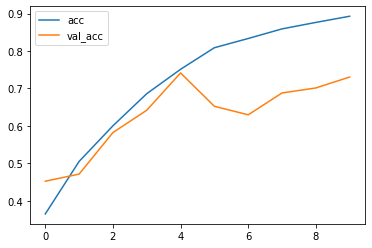

In [20]:
loss[['acc','val_acc']].plot()

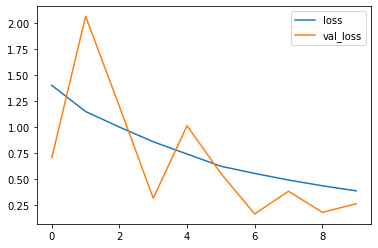

In [21]:
loss[['loss','val_loss']].plot()

#### Save the Model

In [2]:
#third_model.save('blood-cell-classifier.h5')